## 1 Data Collection

### 1.1 Data Import

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
#from pandas.core.common import SettingWithCopyWarning
from pandas_profiling import ProfileReport
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import scikitplot as skplt
from yellowbrick.model_selection import FeatureImportances
import scipy.stats as stats
import joblib
import os
%matplotlib inline

In [2]:
#import dataset
# we have 2 datasets which are application_data and credit_data,
application_data = pd.read_csv('datasets\\application_record.csv')
credit_data = pd.read_csv('datasets\\credit_record.csv')

In [3]:
#preview on first 5 observations of application_data
application_data.head()
application_data.shape


(438557, 18)

In [4]:
#preview on first 5 observations of credit_data
credit_data.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [5]:
#check is any missing value
print('Application data missing value check:\n',application_data.isnull().sum())
print('Credit data missing value check:\n',credit_data.isnull().sum())

Application data missing value check:
 ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64
Credit data missing value check:
 ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64


### 1.2 Merging of datasets

In [6]:
begin_month=pd.DataFrame(credit_data.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})

#merging of both begin_month as Account age
application_data=pd.merge(application_data,begin_month,how='left',on='ID')

#create a new column named bad_debt
credit_data['bad_debt'] = None
credit_data['bad_debt'][credit_data['STATUS'] =='2']='Yes'
credit_data['bad_debt'][credit_data['STATUS'] =='3']='Yes'
credit_data['bad_debt'][credit_data['STATUS'] =='4']='Yes'
credit_data['bad_debt'][credit_data['STATUS'] =='5']='Yes'

status_grouped=credit_data.groupby('ID').count()
status_grouped['bad_debt'][status_grouped['bad_debt'] > 0]='Yes'
status_grouped['bad_debt'][status_grouped['bad_debt'] == 0]='No'

status_grouped = status_grouped[['bad_debt']]

#merge both datasets
application_data = pd.merge(application_data,status_grouped,how='inner',on='ID')
application_data['High_Risk']=application_data['bad_debt']
application_data.loc[application_data['High_Risk']=='Yes','High_Risk']=1
application_data.loc[application_data['High_Risk']=='No','High_Risk']=0

#drop the bad_debt column since mapped to High_Risk
application_data.drop('bad_debt',axis=1,inplace=True)
pd.options.mode.chained_assignment = None # hide warning SettingWithCopyWarning
application_data.head()

C:\Users\Boon\AppData\Local\Temp\ipykernel_50072\2492405813.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_data['bad_debt'][credit_data['STATUS'] =='2']='Yes'
C:\Users\Boon\AppData\Local\Temp\ipykernel_50072\2492405813.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_data['bad_debt'][credit_data['STATUS'] =='3']='Yes'
C:\Users\Boon\AppData\Local\Temp\ipykernel_50072\2492405813.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Account age,High_Risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


### 1.3 Rename features

In [7]:
# rename the features to a more readable feature names
application_data = application_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Own_car',
    'FLAG_OWN_REALTY':'Own_property',
    'CNT_CHILDREN':'Children_count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment_status',
    'NAME_EDUCATION_TYPE':'Education_level',
    'NAME_FAMILY_STATUS':'Marital_status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment_length',
    'FLAG_MOBIL': 'Own_mobile_phone',
    'FLAG_WORK_PHONE': 'Own_work_phone',
    'FLAG_PHONE': 'Own_phone',
    'FLAG_EMAIL': 'Own_email',
    'OCCUPATION_TYPE': 'Job_title',
    'CNT_FAM_MEMBERS': 'Family_member_count',
    'Account age': 'Account_age'
    })
application_data.head()

,ID,Gender,Own_car,Own_property,Children_count,Income,Employment_status,Education_level,Marital_status,Dwelling,Age,Employment_length,Own_mobile_phone,Own_work_phone,Own_phone,Own_email,Job_title,Family_member_count,Account_age,High_Risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


### 1.4 Data savings

In [8]:
# make a copy of the application_data and save into csv
application_data_ori=application_data.copy()
#application_data_ori.to_csv("C:\\Users\\Boon\\Desktop\\UM\\ProgramDS\\Project\\Credit-card-approval-prediction-classification\\datasets\\application_data_ori.csv",index=False)

In [9]:
#overview on the application_data_ori
application_data_ori.shape
application_data_ori['High_Risk'].value_counts()

0    35841
1      616
Name: High_Risk, dtype: int64

## 2 Data Exploration

### 2.0 Pandas Profilling

In [10]:
profile_report = ProfileReport(application_data_ori, explorative=True, dark_mode=True)
profile_report_file_path = Path('pandas_profile_file/credit_pred_profile.html')

# checking if the pandas profile report file exists in the current directory
try:
    profile_report_file_path.resolve(strict=True)
except FileNotFoundError:
    profile_report.to_file("pandas_profile_file/credit_pred_profile.html")

In [11]:
application_data.head()

,ID,Gender,Own_car,Own_property,Children_count,Income,Employment_status,Education_level,Marital_status,Dwelling,Age,Employment_length,Own_mobile_phone,Own_work_phone,Own_phone,Own_email,Job_title,Family_member_count,Account_age,High_Risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


In [12]:
application_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Own_car              36457 non-null  object 
 3   Own_property         36457 non-null  object 
 4   Children_count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment_status    36457 non-null  object 
 7   Education_level      36457 non-null  object 
 8   Marital_status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment_length    36457 non-null  int64  
 12  Own_mobile_phone     36457 non-null  int64  
 13  Own_work_phone       36457 non-null  int64  
 14  Own_phone            36457 non-null  int64  
 15  Own_email            36457 non-null 

In [13]:
# describe numerical features
application_data.describe()

,ID,Children_count,Income,Age,Employment_length,Own_mobile_phone,Own_work_phone,Own_phone,Own_email,Family_member_count,Account_age
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453,-26.164193
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686,16.501854
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000


<AxesSubplot: >

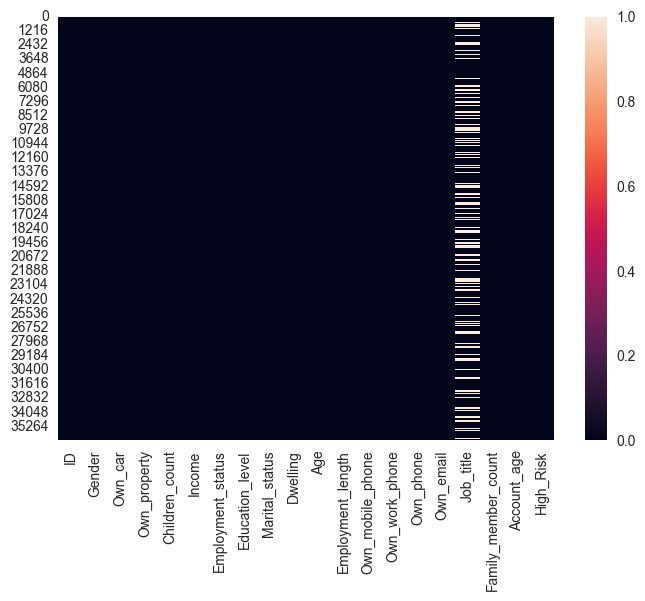

In [14]:
#checking for null value
sns.heatmap(application_data.isnull())

Job tittle has many missing values, thus considering of removing of this feature

# 3.0 Data Preparatiton

## 3.1 Transformation on data

ID-Drop the feature

Gender-One Hot Encoding

Age: Min-max scaling, fix skewness, get the absolute value and divide by 365.25 days into years.

Marital_status: One hot encoding

Family_member_count: Fix outliers

Children_count: Drop Feature

Dwelling_type: One hot encoding

Income: Remove outliers, fix skewness, min-max scaling

Job_title: Drop feature

Employment_status: One hot encoding

Education_level: Ordinal encoding

Employment_length: remove outliers, min-max scaling, abs value and dived by 365.25 days, change days of employments of retirees to 0

Own_a_car: Change to Numerical, one-hot encoding

Own_a_property: Change to Numerical, one-hot encoding

Own_a_mobile_phone: one-hot encoding

Own_an_email: one-hot encoding

Account_age: Drop feature

High_Risk (Target0: Change to Numerical, data balancing with SMOTE

## 3.2 Data cleaning

### 3.2.1 Drop Features

In [15]:
features_to_drop=['Account_age','Job_title','Own_mobile_phone','Children_count','ID']
for feature in features_to_drop:
    application_data.drop(feature,axis=1,inplace=True)
application_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               36457 non-null  object 
 1   Own_car              36457 non-null  object 
 2   Own_property         36457 non-null  object 
 3   Income               36457 non-null  float64
 4   Employment_status    36457 non-null  object 
 5   Education_level      36457 non-null  object 
 6   Marital_status       36457 non-null  object 
 7   Dwelling             36457 non-null  object 
 8   Age                  36457 non-null  int64  
 9   Employment_length    36457 non-null  int64  
 10  Own_work_phone       36457 non-null  int64  
 11  Own_phone            36457 non-null  int64  
 12  Own_email            36457 non-null  int64  
 13  Family_member_count  36457 non-null  float64
 14  High_Risk            36457 non-null  object 
dtypes: float64(2), int64(5), object(8)
m

### 3.2.3 Outliers Removal

In [16]:
def getOutliers(df,col):
    Q1, Q3 = df[col].quantile([0.25,0.75])
    IQR = Q3 - Q1
    right = Q3 + 1.5 * IQR
    left = Q1 - 1.5 * IQR
    df = df[~((df[col] < left) |(df[col] > right))]
    return df

In [17]:
features_with_outliers=['Family_member_count','Income','Employment_length']
for feature in features_with_outliers:
    application_data=getOutliers(application_data,feature)

### 3.2.4 Retiree handling (in the employment length feature)

In [18]:
application_data['Employment_length']=application_data['Employment_length'].replace(365243,0)

### 3.2.5 Time conversion (Day to Year) 

In [19]:
application_data[['Employment_length', 'Age']]=np.abs(application_data[['Employment_length', 'Age']])/365
application_data.describe()


,Income,Age,Employment_length,Own_work_phone,Own_phone,Own_email,Family_member_count
count,26693.000000,26693.000000,26693.000000,26693.000000,26693.000000,26693.000000,26693.000000
mean,179128.549957,39.866619,6.033651,0.271757,0.288053,0.100438,2.258607
std,71031.442395,9.500201,4.461900,0.444873,0.452864,0.300589,0.864441
min,27000.000000,20.517808,0.046575,0.000000,0.000000,0.000000,1.000000
25%,130500.000000,32.071233,2.476712,0.000000,0.000000,0.000000,2.000000
50%,162000.000000,39.079452,4.934247,0.000000,0.000000,0.000000,2.000000
75%,225000.000000,46.967123,8.646575,1.000000,1.000000,0.000000,3.000000
max,378000.000000,66.983562,19.739726,1.000000,1.000000,1.000000,4.000000


### 3.2.6 Skewness handling

In [20]:
# Handle skewness with cubic root transformation
features_to_handle=['Income','Age']
for feature in features_to_handle:
    application_data[feature] = np.cbrt(application_data[feature])

### 3.2.7 Binning

In [21]:
features_to_bin=['Own_work_phone','Own_phone','Own_email']
for ft in features_to_bin:
     application_data[ft] = application_data[ft].map({1:'Y',0:'N'})

In [22]:
application_data.head(10)

,Gender,Own_car,Own_property,Income,Employment_status,Education_level,Marital_status,Dwelling,Age,Employment_length,Own_work_phone,Own_phone,Own_email,Family_member_count,High_Risk
2,M,Y,Y,48.274469,Working,Secondary / secondary special,Married,House / apartment,3.889317,3.106849,N,N,N,2.0,0
3,F,N,Y,64.633041,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,3.741013,8.358904,N,Y,Y,1.0,0
4,F,N,Y,64.633041,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,3.741013,8.358904,N,Y,Y,1.0,0
5,F,N,Y,64.633041,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,3.741013,8.358904,N,Y,Y,1.0,0
6,F,N,Y,64.633041,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,3.741013,8.358904,N,Y,Y,1.0,0
10,M,Y,Y,64.633041,Working,Higher education,Married,House / apartment,3.588871,2.106849,Y,Y,Y,2.0,0
11,M,Y,Y,64.633041,Working,Higher education,Married,House / apartment,3.588871,2.106849,Y,Y,Y,2.0,0
12,M,Y,Y,51.299278,Commercial associate,Secondary / secondary special,Married,House / apartment,3.651994,3.271233,N,N,N,2.0,0
13,M,Y,Y,51.299278,Commercial associate,Secondary / secondary special,Married,House / apartment,3.651994,3.271233,N,N,N,2.0,0
14,M,Y,Y,51.299278,Commercial associate,Secondary / secondary special,Married,House / apartment,3.651994,3.271233,N,N,N,2.0,0


### 3.2.7 Ordinal encoding (with feature's names)

In [23]:
data = np.asarray([['Academic degree', 1], ['Higher education', 2], ['Incomplete higher', 3],['Secondary / secondary special', 4]])
ordinal_enc = OrdinalEncoder()
application_data[['Education_level']]=ordinal_enc.fit_transform(application_data[['Education_level']])
application_data.head(10)

,Gender,Own_car,Own_property,Income,Employment_status,Education_level,Marital_status,Dwelling,Age,Employment_length,Own_work_phone,Own_phone,Own_email,Family_member_count,High_Risk
2,M,Y,Y,48.274469,Working,4.0,Married,House / apartment,3.889317,3.106849,N,N,N,2.0,0
3,F,N,Y,64.633041,Commercial associate,4.0,Single / not married,House / apartment,3.741013,8.358904,N,Y,Y,1.0,0
4,F,N,Y,64.633041,Commercial associate,4.0,Single / not married,House / apartment,3.741013,8.358904,N,Y,Y,1.0,0
5,F,N,Y,64.633041,Commercial associate,4.0,Single / not married,House / apartment,3.741013,8.358904,N,Y,Y,1.0,0
6,F,N,Y,64.633041,Commercial associate,4.0,Single / not married,House / apartment,3.741013,8.358904,N,Y,Y,1.0,0
10,M,Y,Y,64.633041,Working,1.0,Married,House / apartment,3.588871,2.106849,Y,Y,Y,2.0,0
11,M,Y,Y,64.633041,Working,1.0,Married,House / apartment,3.588871,2.106849,Y,Y,Y,2.0,0
12,M,Y,Y,51.299278,Commercial associate,4.0,Married,House / apartment,3.651994,3.271233,N,N,N,2.0,0
13,M,Y,Y,51.299278,Commercial associate,4.0,Married,House / apartment,3.651994,3.271233,N,N,N,2.0,0
14,M,Y,Y,51.299278,Commercial associate,4.0,Married,House / apartment,3.651994,3.271233,N,N,N,2.0,0


### 3.2.8 One-hot encoding (with feature's name)

In [24]:
features_to_one_hot=['Gender', 'Marital_status', 'Dwelling', 'Employment_status', 'Own_car', 'Own_property', 'Own_work phone', 'Own_phone', 'Own_email']

In [25]:
def one_hot_enc(df,one_hot_enc_ft):
    one_hot_enc = OneHotEncoder()
    one_hot_enc.fit(df[one_hot_enc_ft])
    # get the result of the one hot encoding columns names
    feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
    # change the array of the one hot encoding to a dataframe with the column names
    df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(),columns=feat_names_one_hot_enc,index=df.index)
    return df

In [26]:
def one_hot_enc(df,one_hot_enc_ft):
    one_hot_enc = OneHotEncoder()
    one_hot_enc.fit(df[[one_hot_enc_ft]])
    # get the result of the one hot encoding columns names
    feat_names_one_hot_enc = one_hot_enc.get_feature_names_out([one_hot_enc_ft])
    # change the array of the one hot encoding to a dataframe with the column names
    df = pd.DataFrame(one_hot_enc.transform(df[[one_hot_enc_ft]]).toarray(),columns=feat_names_one_hot_enc,index=df.index)
    return df

# function to concatenat the one hot encoded features with the rest of features that were not encoded
def concat_with_rest(df,one_hot_enc_df,one_hot_enc_ft):
    # get the rest of the features
    rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
    # concatenate the rest of the features with the one hot encoded features
    df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]],axis=1)
    return df_concat
    
one_hot_enc_ft=['Gender', 'Marital_status', 'Dwelling', 'Employment_status', 'Own_car', 'Own_property', 'Own_work_phone', 'Own_phone', 'Own_email']
for feat in one_hot_enc_ft:
    
    # one hot encoded dataframe
    one_hot_enc_df = one_hot_enc(application_data,feat)
    
    # returns the concatenated dataframe
    full_df_one_hot_enc = concat_with_rest(application_data,one_hot_enc_df,feat)
    application_data=full_df_one_hot_enc

### 3.2.9 Min-Max scaling (with feature's names)

In [27]:
features_to_scale=['Age', 'Income', 'Employment_length']
for ft in features_to_scale:
    print(f'Min for {ft}: {min(application_data[ft])}')
    print(f'Max for {ft}: {max(application_data[ft])}')
    min_max_enc = MinMaxScaler()
    application_data[[ft]] = min_max_enc.fit_transform(application_data[[ft]])
    print (min_max_enc.scale_)

Min for Age: 2.7376441032733023
Max for Age: 4.061215908230528
[0.75553136]
Min for Income: 30.0
Max for Income: 72.30426792525691
[0.02363828]
Min for Employment_length: 0.04657534246575343
Max for Employment_length: 19.73972602739726
[0.05077908]


In [28]:
np.cbrt(20.517808219178082)

2.7376441032733023

In [29]:
# Min_Age: 20.517808219178082
# Max_Age: 66.98356164383561

# Min_Income: 27000.0
# Max_Income: 378000.0

# Min_Employment_length: 0.04657534246575343
# Max_mployment_length: 19.73972602739726

## for age and income only
#Age
# min_value=2.7376441032733023
# max_value=4.061215908230528

#Income
# min_value= 30.0
# max_value= 72.30426792525691
    
def input_skew(input_value,min_value,max_value):
    x_skewed=np.cbrt(input_value)
    if x_skewed<min_value:
        x_skewed=min_value
    elif x_skewed>max_value:
        x_skewed=max_value
    return x_skewed

#for age, income and employmentt length
#Age
# min_value=2.7376441032733023
# max_value=4.061215908230528

#Income
# min_value= 30.0
# max_value= 72.30426792525691

#employment (in years)
# min_value=0.04657534246575343
# max_value=19.73972602739726

def input_scale(input_value,min_value,max_value):

    x_scaled=(input_value-min_value)/(max_value-min_value)
    if x_scaled<0:
        x_scaled=0
    elif x_scaled>1:
        x_scaled=1
    return x_scaled


In [30]:
## for age and income only
#Age
# min_value=2.7376441032733023
# max_value=4.061215908230528

#Income
# min_value= 30.0
# max_value= 72.30426792525691
    
def input_skew(input_value,min_value,max_value):
    x_skewed=np.cbrt(input_value)
    if x_skewed<min_value:
        x_skewed=min_value
    elif x_skewed>max_value:
        x_skewed=max_value
    return x_skewed

#for age, income and employmentt length
#Age
# min_value=2.7376441032733023
# max_value=4.061215908230528

#Income
# min_value= 30.0
# max_value= 72.30426792525691

#employment (in years)
# min_value=0.04657534246575343
# max_value=19.73972602739726

def input_scale(input_value,min_value,max_value):

    x_scaled=(input_value-min_value)/(max_value-min_value)
    if x_scaled<0:
        x_scaled=0
    elif x_scaled>1:
        x_scaled=1
    return x_scaled

In [31]:
application_data.head()

,Own_email_N,Own_email_Y,Own_phone_N,Own_phone_Y,Own_work_phone_N,Own_work_phone_Y,Own_property_N,Own_property_Y,Own_car_N,Own_car_Y,...,Marital_status_Single / not married,Marital_status_Widow,Gender_F,Gender_M,Income,Education_level,Age,Employment_length,Family_member_count,High_Risk
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.431977,4.0,0.870125,0.155398,2.0,0
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.818665,4.0,0.758077,0.422092,1.0,0
4,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.818665,4.0,0.758077,0.422092,1.0,0
5,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.818665,4.0,0.758077,0.422092,1.0,0
6,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.818665,4.0,0.758077,0.422092,1.0,0


In [32]:
full_df_one_hot_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26693 entries, 2 to 36456
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Own_email_N                             26693 non-null  float64
 1   Own_email_Y                             26693 non-null  float64
 2   Own_phone_N                             26693 non-null  float64
 3   Own_phone_Y                             26693 non-null  float64
 4   Own_work_phone_N                        26693 non-null  float64
 5   Own_work_phone_Y                        26693 non-null  float64
 6   Own_property_N                          26693 non-null  float64
 7   Own_property_Y                          26693 non-null  float64
 8   Own_car_N                               26693 non-null  float64
 9   Own_car_Y                               26693 non-null  float64
 10  Employment_status_Commercial associate  26693 non-null  fl

### 3.2.10 Change the data types of the target feature

In [33]:
application_data['High_Risk'] = pd.to_numeric(application_data['High_Risk'])

In [34]:
application_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26693 entries, 2 to 36456
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Own_email_N                             26693 non-null  float64
 1   Own_email_Y                             26693 non-null  float64
 2   Own_phone_N                             26693 non-null  float64
 3   Own_phone_Y                             26693 non-null  float64
 4   Own_work_phone_N                        26693 non-null  float64
 5   Own_work_phone_Y                        26693 non-null  float64
 6   Own_property_N                          26693 non-null  float64
 7   Own_property_Y                          26693 non-null  float64
 8   Own_car_N                               26693 non-null  float64
 9   Own_car_Y                               26693 non-null  float64
 10  Employment_status_Commercial associate  26693 non-null  fl

In [35]:
application_data.rename(columns = {'Employment_status_Commercial associate':'Employment_status_Commercial_associate', 'Employment_status_State servant':'Employment_status_State_servant','Dwelling_Co-op apartment':'Dwelling_Co_op_apartment',
                                  'Dwelling_House / apartment':'Dwelling_House_apartment','Dwelling_Municipal apartment':'Dwelling_Municipal_apartment','Dwelling_Office apartment':'Dwelling_Office_apartment',
                                  'Dwelling_Rented apartment':'Dwelling_Rented_apartment','Dwelling_With parents':'Dwelling_With_parents',
                                  'Marital_status_Single / not married':'Marital_status_Single_not_married','Marital_status_Civil marriage':'Marital_status_Civil_marriage'}, inplace = True)

In [36]:
application_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26693 entries, 2 to 36456
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Own_email_N                             26693 non-null  float64
 1   Own_email_Y                             26693 non-null  float64
 2   Own_phone_N                             26693 non-null  float64
 3   Own_phone_Y                             26693 non-null  float64
 4   Own_work_phone_N                        26693 non-null  float64
 5   Own_work_phone_Y                        26693 non-null  float64
 6   Own_property_N                          26693 non-null  float64
 7   Own_property_Y                          26693 non-null  float64
 8   Own_car_N                               26693 non-null  float64
 9   Own_car_Y                               26693 non-null  float64
 10  Employment_status_Commercial_associate  26693 non-null  fl

### 3.2.11 Training and Testing set split

In [37]:
# # split the data into train and test
# def data_split(df, test_size):
#     train_df, test_df = train_test_split(df, test_size=test_size,random_state=42)
#     return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [38]:
#train_set,test_set=data_split(application_data,0.15)

In [39]:
X=application_data.loc[:, application_data.columns != 'High_Risk']
y=application_data.loc[:, application_data.columns == 'High_Risk']

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

In [41]:
for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)
X_bal=X_train
y_bal=y_train

(20019, 33)
(6674, 33)
(20019, 1)
(6674, 1)


In [42]:
train_set= X_train.join(y_train)
test_set= X_test.join(y_test)

In [43]:
print('Train set shape:',train_set.shape)
print('Test set shape',test_set.shape)
print('\nTrain set label counts:\n',train_set['High_Risk'].value_counts())
print('\nTest set label counts:\n',test_set['High_Risk'].value_counts())

Train set shape: (20019, 34)
Test set shape (6674, 34)

Train set label counts:
 0    19688
1      331
Name: High_Risk, dtype: int64

Test set label counts:
 0    6564
1     110
Name: High_Risk, dtype: int64


In [44]:
#oversampling
oversample = SMOTE(sampling_strategy='minority')
X_bal, y_bal = oversample.fit_resample(train_set.loc[:, train_set.columns != 'High_Risk'],train_set['High_Risk'])
X_bal.info()
y_bal.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39376 entries, 0 to 39375
Data columns (total 33 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Own_email_N                             39376 non-null  float64
 1   Own_email_Y                             39376 non-null  float64
 2   Own_phone_N                             39376 non-null  float64
 3   Own_phone_Y                             39376 non-null  float64
 4   Own_work_phone_N                        39376 non-null  float64
 5   Own_work_phone_Y                        39376 non-null  float64
 6   Own_property_N                          39376 non-null  float64
 7   Own_property_Y                          39376 non-null  float64
 8   Own_car_N                               39376 non-null  float64
 9   Own_car_Y                               39376 non-null  float64
 10  Employment_status_Commercial_associate  39376 non-null  fl

0    19688
1    19688
Name: High_Risk, dtype: int64

In [45]:
x_test=test_set.loc[:, test_set.columns != 'High_Risk']
x_test.head()
y_test=test_set.loc[:, test_set.columns == 'High_Risk']
y_test.head()

,High_Risk
5026,0
4443,1
16145,0
9346,0
28615,0


In [46]:
# #oversampling dont use it
# oversample = SMOTE(sampling_strategy=0.05)
# x_test, y_test = oversample.fit_resample(test_set.loc[:, train_set.columns != 'High_Risk'],test_set['High_Risk'])

## 4 Modelling

In [47]:
#!pip uninstall scikit-learn -y
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt  
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc,roc_curve,f1_score,roc_auc_score,precision_recall_fscore_support
from scikitplot.metrics import plot_roc_curve
# Import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

# Import Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Import Support Vector Machines
from sklearn.svm import SVC

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [48]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings("ignore")

In [49]:
import matplotlib.pyplot as plt
def fun_plot_roc_curve(true_y, y_prob,title):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    acc=roc_auc_score(true_y,y_prob)
    plt.plot(fpr, tpr,label='(AUROC = %0.3f)' % acc)
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend() # 
    # Show plot
    plt.show()

def fun_plot_confusion_matrix(y_test,y_predict,model):
    cm = confusion_matrix(y_test, y_predict, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot(cmap = 'Blues')
    plt.show()

In [50]:
from yellowbrick.model_selection import FeatureImportances
# Function to get the feature importance of the classifier, and plot it
def feat_importance_plot(model_trn, model_name):
    if model_name not in ['sgd','support_vector_machine','gaussian_naive_bayes','k_nearest_neighbors','bagging','neural_network']:
        # change xtick font size
        plt.rcParams['xtick.labelsize'] = 12
        plt.rcParams['ytick.labelsize'] = 12
        # top 10 most predictive features
        top_10_feat = FeatureImportances(model_trn, relative=False, topn=10)
        # top 10 least predictive features
        bottom_10_feat = FeatureImportances(model_trn, relative=False, topn=-10)
        #change the figure size
        plt.figure(figsize=(10, 4))
        #change x label font size
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the feature importances
        top_10_feat.fit(X_bal, y_bal)
        # show the plot
        top_10_feat.show()
        print('\n')
        plt.figure(figsize=(10, 4))
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the feature importances
        bottom_10_feat.fit(X_bal, y_bal)
        # show the plot
        bottom_10_feat.show()
        print('\n')
    else:
        print('No feature importance for {0}'.format(model_name))
        print('\n')

In [51]:
#result_list for storing outcomes and convert to df later
result_list=[]

## Random Forest

### RandomizedSearchCV

!!!DONT RUN THE CELL BELOW, else you ll need to wait it done, might take few hours based on your pc spec

The cell below is commented due to long execution time for tuning during every compilation, however, the beast parameters tuned previously is saved and implemented in the next cell.

In [54]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 400, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_bal, y_bal)
# rf_random.best_params_

In [55]:
# Best parameters for randomisedsearchcv for random forest, backup if any error
from sklearn.model_selection import RandomizedSearchCV
random_grid={'n_estimators': [222],
 'min_samples_split': [2],
 'min_samples_leaf': [1],
 'max_features': ['sqrt'],
 'max_depth': [None],
 'bootstrap': [False]}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_bal, y_bal)
rf_random.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


{'n_estimators': 222,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

Random Forest (RandomizedSearchCV tuned)
Accuracy score:  0.980521426430926
ROC_AUC_Score:  0.6504321090244307
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6564
           1       0.39      0.31      0.34       110

    accuracy                           0.98      6674
   macro avg       0.69      0.65      0.67      6674
weighted avg       0.98      0.98      0.98      6674



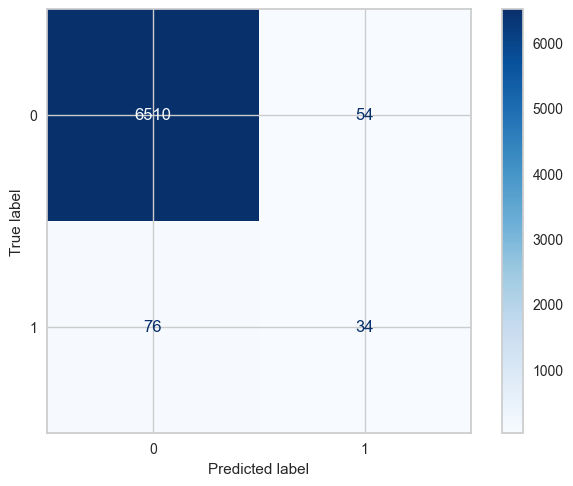

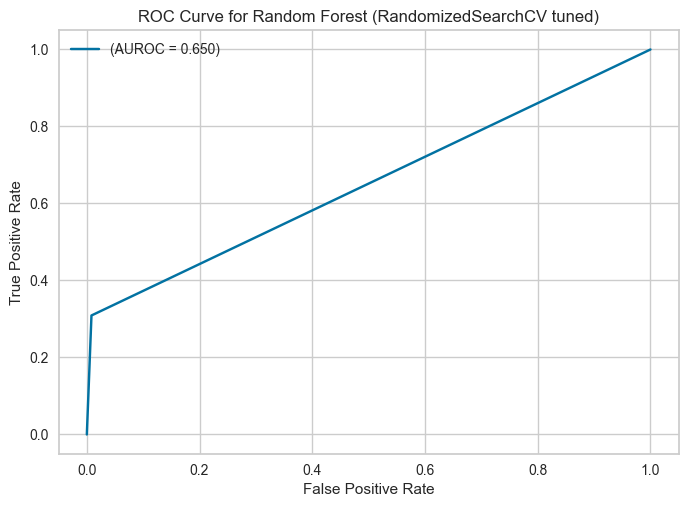

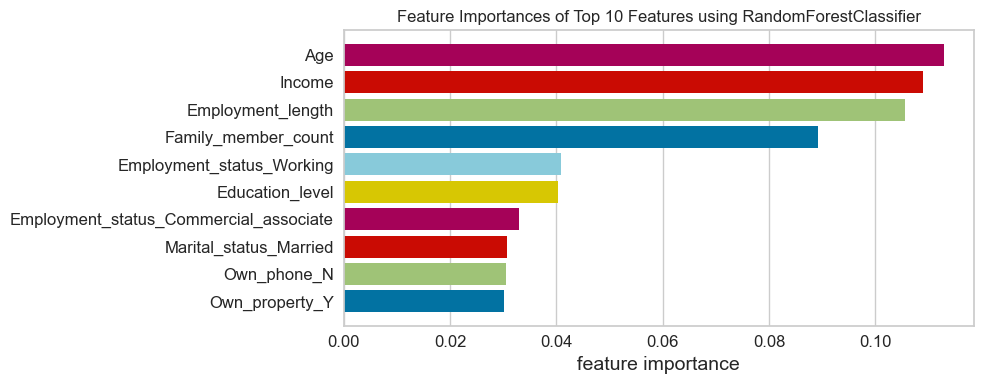

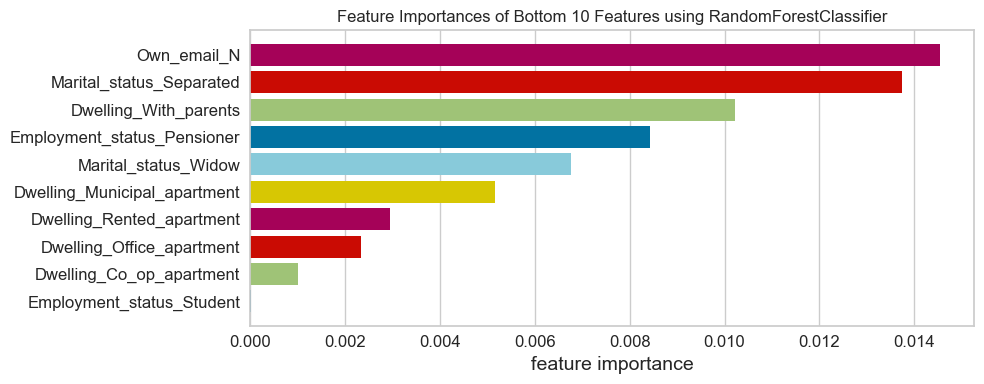

In [56]:
#Prediction with best Randomised searcged model
rf_model=rf_random.best_estimator_
rf_model.fit(X_bal,y_bal)
rf_model.predict(x_test)
rf_pred = rf_model.predict(x_test)
print('Random Forest (RandomizedSearchCV tuned)')
rf_pred_acc=accuracy_score(y_test,rf_pred)
print('Accuracy score: ',rf_pred_acc)
rf_pred_roc_auc_scoring=roc_auc_score(y_test,rf_pred)
print('ROC_AUC_Score: ',rf_pred_roc_auc_scoring)
print(classification_report(y_test,rf_pred))

fun_plot_confusion_matrix(y_test,rf_pred,rf_model)
fun_plot_roc_curve(y_test,rf_pred,'ROC Curve for Random Forest (RandomizedSearchCV tuned)')
feat_importance_plot(rf_model,'Random_forest_RandomisedSearch')

rf_pred_precision_score,rf_pred_recall_score,rf_pred_f1_score,_=precision_recall_fscore_support(y_test,rf_pred,average='weighted')
result_list.append(['Random Forest (RandomisedSearchCV)',rf_pred_acc,rf_pred_roc_auc_scoring,rf_pred_precision_score,rf_pred_recall_score,rf_pred_f1_score])

### Random Forest GridSearchCV 

!!!DONT RUN THE CELL BELOW, else you ll need to wait it done, might take few hours based on your pc spec

The cell below is commented due to long execution time for tuning during every compilation, however, the beast parameters tuned previously is saved and implemented in the next cell.

In [57]:
##Commented to avoid miss running on this cell, take time to get result, the parameters are in nexxt cell

# from sklearn.model_selection import GridSearchCV
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [False],
#     'max_depth': [None,10,30,50,70,90],
#     'max_features': [2, 3,5,'Auto'],
#     'min_samples_leaf': [2, 3, 4,5],
#     'min_samples_split': [2, 5, 8, 11],
#     'n_estimators': [100,200,300,400,500]
# }
# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 5, n_jobs = -1, verbose = 2)
# grid_search.fit(X_bal, y_bal)
# grid_search.best_params_

In [58]:
# Best parameters for gridsearchcv for random forest, backup if any error
param_grid={'bootstrap': [False],
 'max_depth': [None],
 'max_features': [5],
 'min_samples_leaf': [2],
 'min_samples_split': [2],
 'n_estimators': [300]}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(X_bal, y_bal)
grid_search.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'bootstrap': False,
 'max_depth': None,
 'max_features': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

Random Forest (GridSearhCV tuned)
Accuracy score:  0.9802217560683248
ROC_AUC_Score:  0.6458104814137722
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6564
           1       0.38      0.30      0.33       110

    accuracy                           0.98      6674
   macro avg       0.68      0.65      0.66      6674
weighted avg       0.98      0.98      0.98      6674



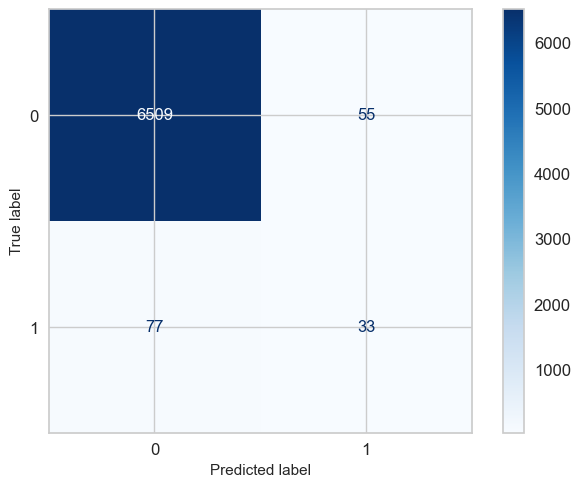

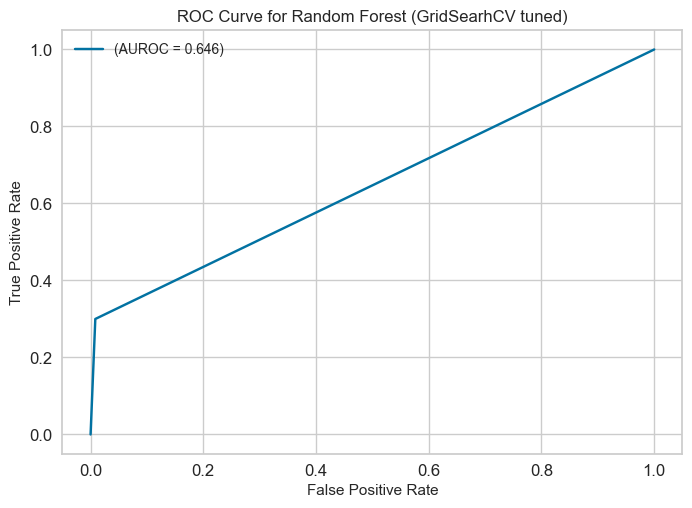

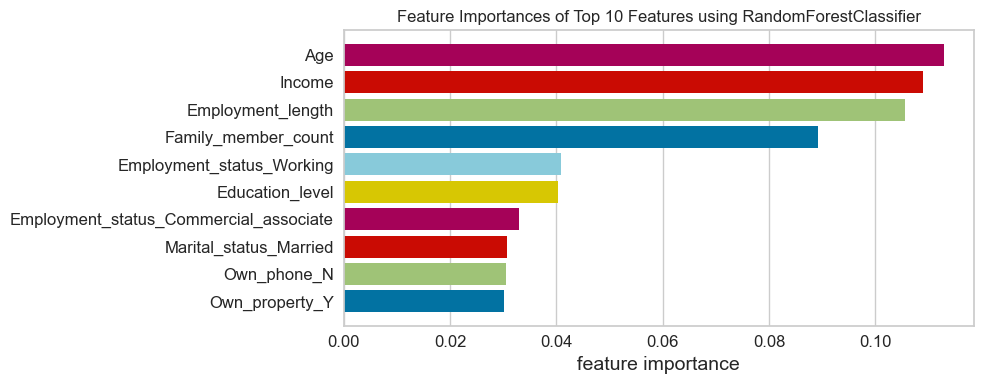

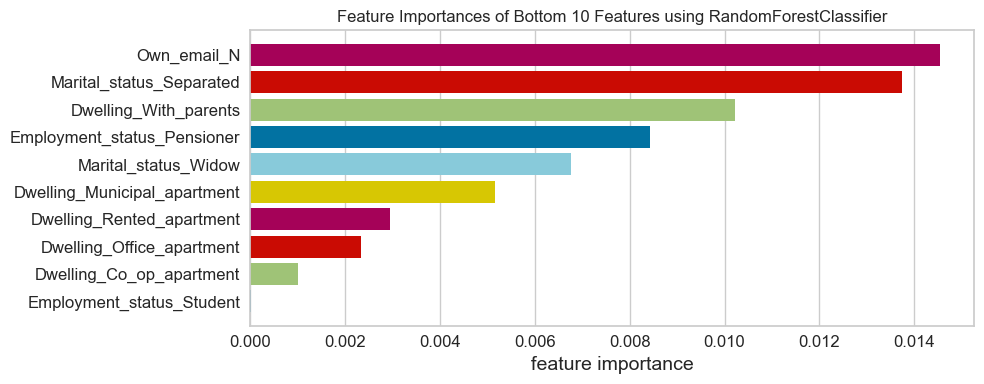

In [59]:
rf_model_grid=grid_search.best_estimator_
rf_model_grid.fit(X_bal,y_bal)

rf_pred_grid = rf_model_grid.predict(x_test)
print('Random Forest (GridSearhCV tuned)')
rf_pred_grid_acc=accuracy_score(y_test,rf_pred_grid)
print('Accuracy score: ',rf_pred_grid_acc)
rf_pred_grid_roc=roc_auc_score(y_test,rf_pred_grid)
print('ROC_AUC_Score: ',rf_pred_grid_roc)
print(classification_report(y_test,rf_pred_grid))

fun_plot_confusion_matrix(y_test,rf_pred_grid,rf_model_grid)
fun_plot_roc_curve(y_test,rf_pred_grid,'ROC Curve for Random Forest (GridSearhCV tuned)')
feat_importance_plot(rf_model,'random_forest')

rf_pred_grid_precision_score,rf_pred_grid_recall_score,rf_pred_grid_f1_score,_=precision_recall_fscore_support(y_test,rf_pred_grid,average='weighted')
result_list.append(['Random Forest (GridSearhCV)',rf_pred_grid_acc,rf_pred_grid_roc,rf_pred_grid_precision_score,rf_pred_grid_recall_score,rf_pred_grid_f1_score])

In [ ]:
# feature_importances = np.mean([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
# feature_importances

## XGBoost

### XGBoost (Default) on Balanced Train Set with SMOTE

XGBoost-Default
Accuracy score:  0.9797722505244232
ROC_AUC_Score:  0.627704836297158
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6564
           1       0.35      0.26      0.30       110

    accuracy                           0.98      6674
   macro avg       0.67      0.63      0.65      6674
weighted avg       0.98      0.98      0.98      6674



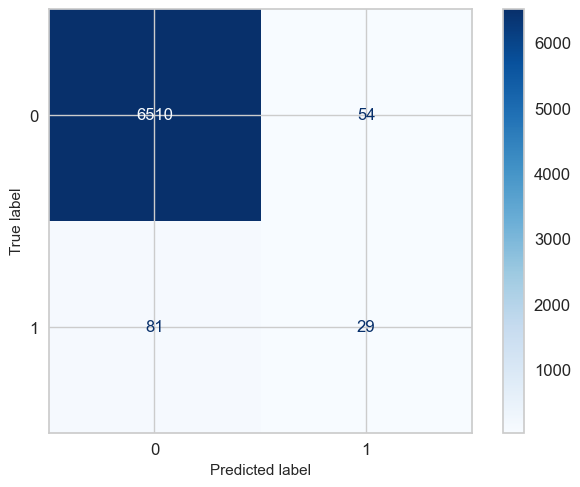

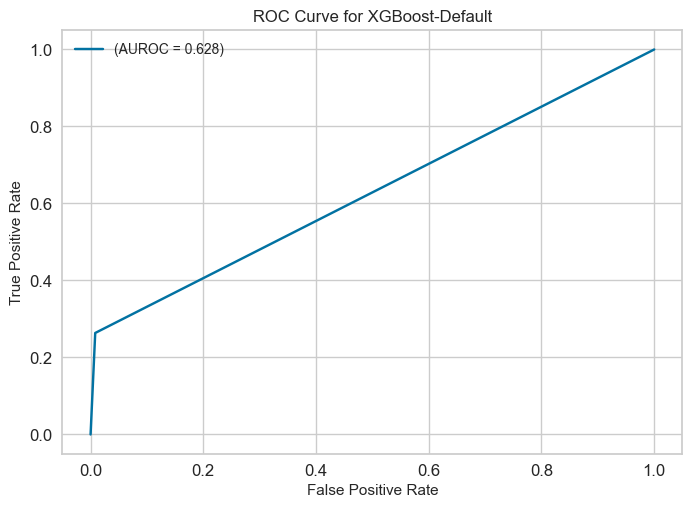

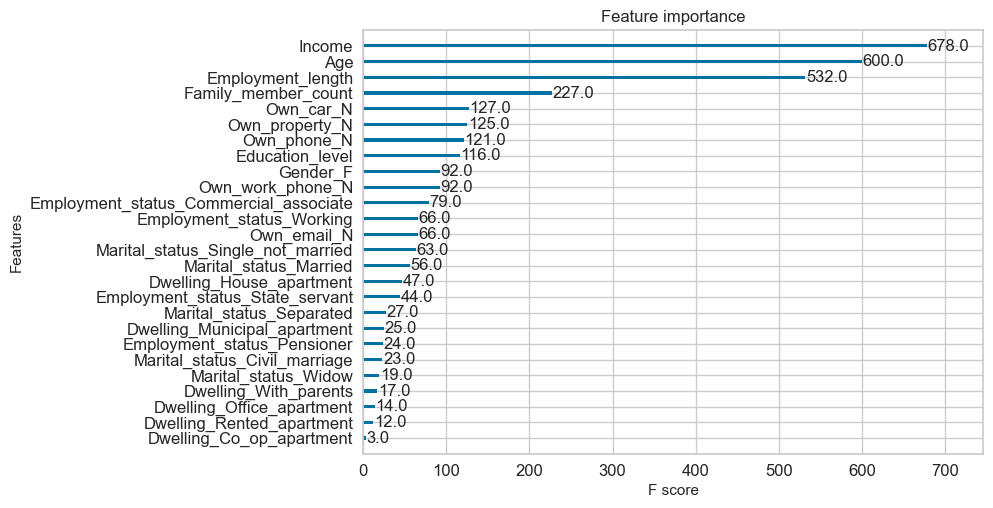

In [60]:
#modelling
# model = XGBClassifier(max_depth=12,
#                       n_estimators=250,
#                       min_child_weight=8, 
#                       subsample=0.8, 
#                       learning_rate =0.02,    
#                       seed=42)
xgb_model = XGBClassifier()
xgb_model.fit(X_bal, y_bal)
xgb_predict = xgb_model.predict(x_test)

print('XGBoost-Default')
xgb_predict_acc=accuracy_score(y_test,xgb_predict)
print('Accuracy score: ',xgb_predict_acc)
xgb_predict_roc=roc_auc_score(y_test,xgb_predict)
print('ROC_AUC_Score: ',roc_auc_score(y_test,xgb_predict))

print(classification_report(y_test,xgb_predict))
fun_plot_confusion_matrix(y_test,xgb_predict,xgb_model)
fun_plot_roc_curve(y_test,xgb_predict,'ROC Curve for XGBoost-Default')

from xgboost import plot_importance
# plot feature importance
plot_importance(xgb_model)
plt.show()

xgb_predict_precision_score,xgb_predict_recall_score,xgb_predict_f1_score,_=precision_recall_fscore_support(y_test,xgb_predict,average='weighted')
result_list.append(['XGBoost-Default',xgb_predict_acc,xgb_predict_roc,xgb_predict_precision_score,xgb_predict_recall_score,xgb_predict_f1_score])

### XGBoost RandomSearchCV

!!!DONT RUN THE CELL BELOW, else you ll need to wait it done, might take few hours based on your pc spec

The cell below is commented due to long execution time for tuning during every compilation, however, the beast parameters tuned previously is saved and implemented in the next cell.

In [61]:
# from sklearn.model_selection import RandomizedSearchCV
# import xgboost
# xgboost_rs_classifier = xgboost.XGBClassifier()
# params = {
#  'n_estimators':[100,200,300,400,500],
#  'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
#  'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
#  'min_child_weight' : [ 1, 3, 5, 7, 9],
#  'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
#  'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
# }

In [62]:
# xgboost_rs_model=RandomizedSearchCV(xgboost_rs_classifier,param_distributions=params,n_iter=100,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
# xgboost_rs_model.fit(X,y)
# xgboost_rs_model.best_params_

In [65]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost

xgboost_rs_classifier = xgboost.XGBClassifier()
params ={'n_estimators': [300],
 'min_child_weight': [9],
 'max_depth': [4],
 'learning_rate': [0.25],
 'gamma': [0.2],
 'colsample_bytree': [0.4]}
xgboost_rs_model=RandomizedSearchCV(xgboost_rs_classifier,param_distributions=params,n_iter=100,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
xgboost_rs_model.fit(X_bal,y_bal)
xgboost_rs_model.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'n_estimators': 300,
 'min_child_weight': 9,
 'max_depth': 4,
 'learning_rate': 0.25,
 'gamma': 0.2,
 'colsample_bytree': 0.4}

XGBoost-RandomisedSearch
Accuracy score:  0.9788732394366197
ROC_AUC_Score:  0.6227785164256827
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6564
           1       0.32      0.25      0.28       110

    accuracy                           0.98      6674
   macro avg       0.65      0.62      0.64      6674
weighted avg       0.98      0.98      0.98      6674



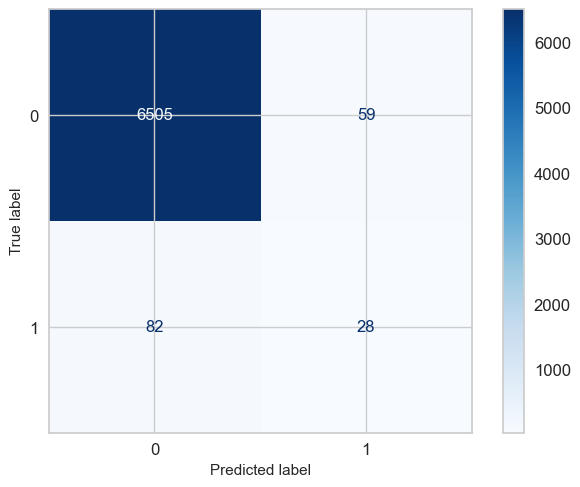

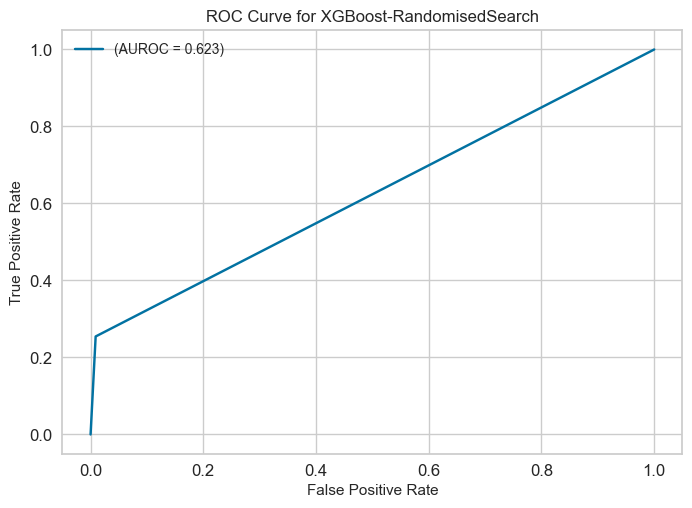

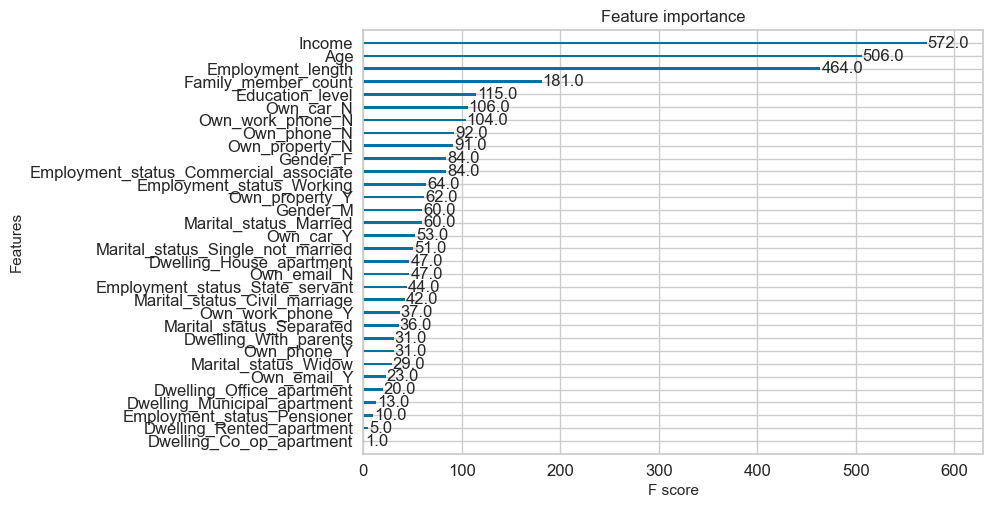

In [66]:
xgb_rs_model_tuned=xgboost_rs_model.best_estimator_
xgb_rs_model_tuned.fit(X_bal,y_bal)
xgb_rs_model_preds=xgb_rs_model_tuned.predict(x_test)

print('XGBoost-RandomisedSearch')
xgb_rs_model_preds_acc=accuracy_score(y_test,xgb_rs_model_preds)
print('Accuracy score: ',xgb_rs_model_preds_acc)
xgb_rs_model_preds_roc=roc_auc_score(y_test,xgb_rs_model_preds)
print('ROC_AUC_Score: ',xgb_rs_model_preds_roc)

print(classification_report(y_test,xgb_rs_model_preds))
fun_plot_confusion_matrix(y_test,xgb_rs_model_preds,xgb_rs_model_tuned)
fun_plot_roc_curve(y_test,xgb_rs_model_preds,'ROC Curve for XGBoost-RandomisedSearch')
from xgboost import plot_importance
# plot feature importance
plot_importance(xgb_rs_model_tuned)
plt.show()

xgb_rs_model_preds_precision_score,xgb_rs_model_preds_recall_score,xgb_rs_model_preds_f1_score,_=precision_recall_fscore_support(y_test,xgb_rs_model_preds,average='weighted')
result_list.append(['XGBoost (RandomisedSearchCV)',xgb_rs_model_preds_acc,xgb_rs_model_preds_roc,xgb_rs_model_preds_precision_score,xgb_rs_model_preds_recall_score,xgb_rs_model_preds_f1_score])

### XGBoost GridSearchCV

!!!DONT RUN THE CELL BELOW, else you ll need to wait it done, might take few hours based on your pc spec

The cell below is commented due to long execution time for tuning during every compilation, however, the beast parameters tuned previously is saved and implemented in the next cell.

In [67]:
# from sklearn.model_selection import GridSearchCV
# import xgboost
# xgboost_gs_classifier = xgboost.XGBClassifier()
# gs_params = {
#  'n_estimators':[200,250,300,350],
#  'learning_rate' : [0.10,0.20,0.80],
#  'max_depth' : [5,10,15],
#  'min_child_weight' : [5, 7, 9],
#  'gamma': [ 0.3,0.4,0.5 ],
#  'colsample_bytree' : [0.4, 0.5 , 0.7]
# }

In [68]:
# xgboost_gs_model=GridSearchCV(xgboost_gs_classifier,param_grid=gs_params,scoring='neg_log_loss',n_jobs=-1,cv=5,verbose=3)
# xgboost_gs_model.fit(X_bal,y_bal)
# xgboost_gs_model.best_params_

In [69]:
from sklearn.model_selection import GridSearchCV
import xgboost
xgboost_gs_classifier = xgboost.XGBClassifier()
gs_params ={'colsample_bytree': [0.4],
 'gamma': [0.3],
 'learning_rate': [0.1],
 'max_depth': [5],
 'min_child_weight': [9],
 'n_estimators': [200]}
xgboost_gs_model=GridSearchCV(xgboost_gs_classifier,param_grid=gs_params,scoring='neg_log_loss',n_jobs=-1,cv=5,verbose=3)
xgboost_gs_model.fit(X_bal,y_bal)
xgboost_gs_model.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'colsample_bytree': 0.4,
 'gamma': 0.3,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 9,
 'n_estimators': 200}

XGBoost-GridSearch
Accuracy score:  0.9748276895415043
ROC_AUC_Score:  0.61178328070467
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6564
           1       0.24      0.24      0.24       110

    accuracy                           0.97      6674
   macro avg       0.61      0.61      0.61      6674
weighted avg       0.97      0.97      0.97      6674



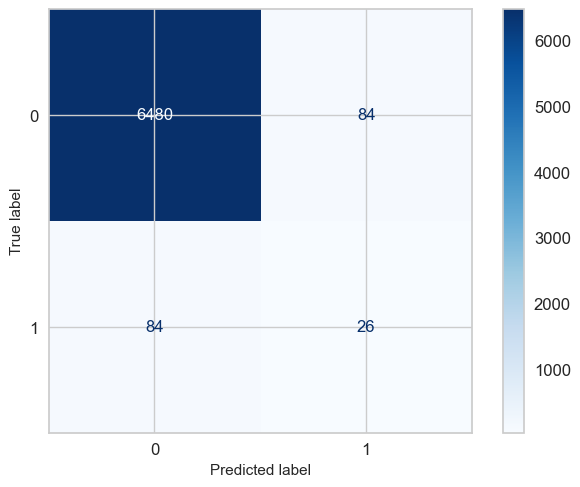

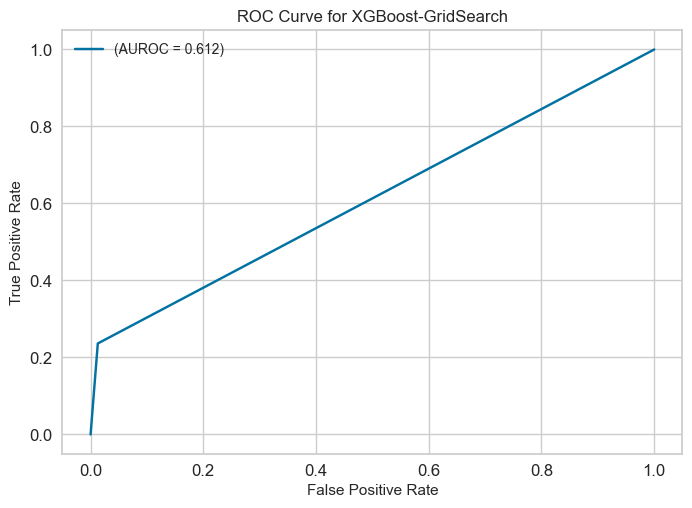

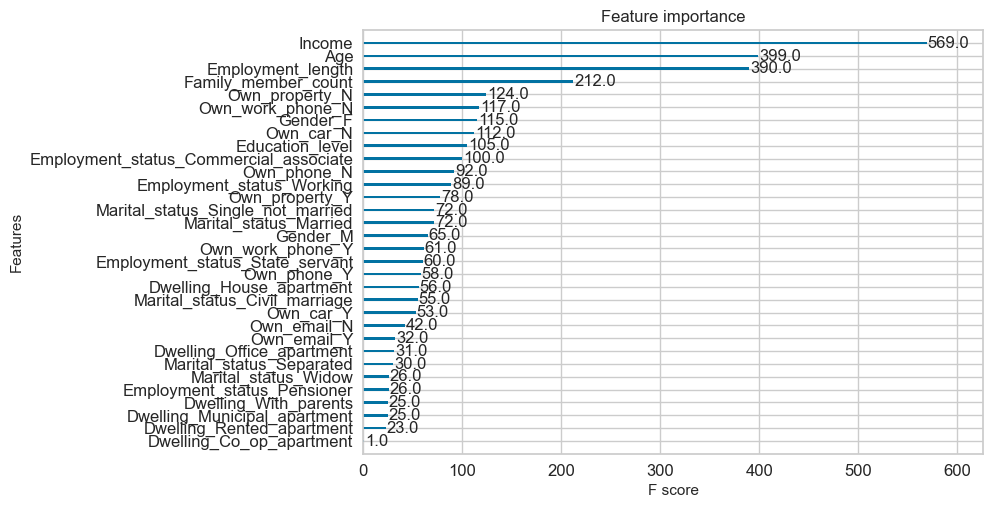

In [70]:
xgb_gs_model_tuned=xgboost_gs_model.best_estimator_
xgb_gs_model_tuned.fit(X_bal,y_bal)
xgb_gs_model_preds=xgb_gs_model_tuned.predict(x_test)

print('XGBoost-GridSearch')
xgb_gs_model_preds_acc=accuracy_score(y_test,xgb_gs_model_preds)
print('Accuracy score: ',xgb_gs_model_preds_acc)
xgb_gs_model_preds_roc=roc_auc_score(y_test,xgb_gs_model_preds)
print('ROC_AUC_Score: ',xgb_gs_model_preds_roc)

print(classification_report(y_test,xgb_gs_model_preds))
fun_plot_confusion_matrix(y_test,xgb_gs_model_preds,xgb_gs_model_tuned)
fun_plot_roc_curve(y_test,xgb_gs_model_preds,'ROC Curve for XGBoost-GridSearch')
from xgboost import plot_importance
# plot feature importance
plot_importance(xgb_gs_model_tuned)
plt.show()

xgb_gs_model_preds_precision_score,xgb_gs_model_preds_recall_score,xgb_gs_model_preds_f1_score,_=precision_recall_fscore_support(y_test,xgb_gs_model_preds,average='weighted')
result_list.append(['XGBoost (GridSearchCV)',xgb_gs_model_preds_acc,xgb_gs_model_preds_roc,xgb_gs_model_preds_precision_score,xgb_gs_model_preds_recall_score,xgb_gs_model_preds_f1_score])

## Balanced Bagging Classifier

### Balanced Bagging Classifier with Base Estimator-XGBoost (Unbalanced Train Set)

Balanced Bagging Classifier-XGBoost
Accuracy score :  0.8224453101588253
ROC_AUC_Score:  0.6639244363193175
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      6564
           1       0.05      0.50      0.08       110

    accuracy                           0.82      6674
   macro avg       0.52      0.66      0.49      6674
weighted avg       0.97      0.82      0.89      6674



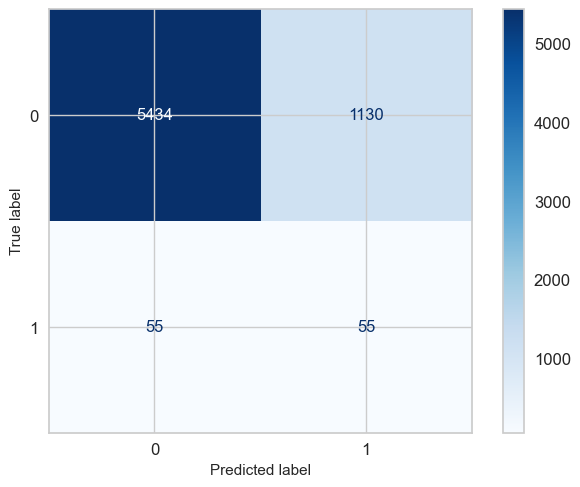

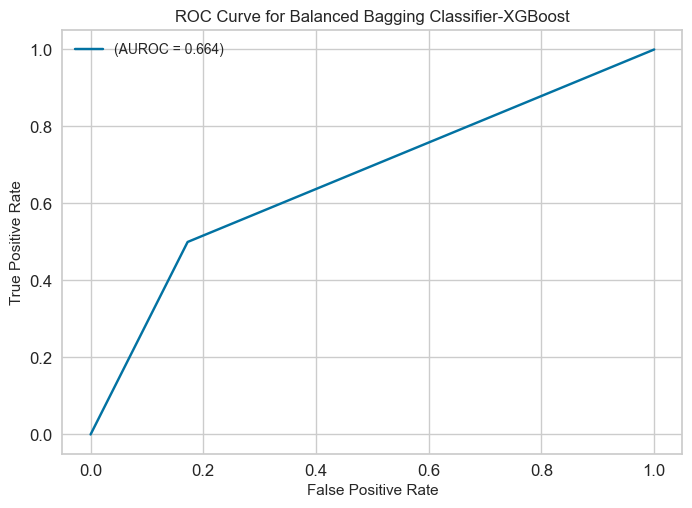

In [71]:
xgb_bbc=BalancedBaggingClassifier(base_estimator=XGBClassifier(n_estimators=100,objective='binary:logistic',eval_metric='logloss'),
                             sampling_strategy='auto',
                             replacement=False,
                             random_state=0)

xgb_bbc.fit(X_train,y_train)
xgb_bbc_predict=xgb_bbc.predict(x_test)
print('Balanced Bagging Classifier-XGBoost')
xgb_bbc_predict_acc=accuracy_score(y_test,xgb_bbc_predict)
print('Accuracy score : ',xgb_bbc_predict_acc)
xgb_bbc_predict_roc=roc_auc_score(y_test,xgb_bbc_predict)
print('ROC_AUC_Score: ',xgb_bbc_predict_roc)

print(classification_report(y_test,xgb_bbc_predict))
fun_plot_confusion_matrix(y_test,xgb_bbc_predict,xgb_bbc)
fun_plot_roc_curve(y_test,xgb_bbc_predict,'ROC Curve for Balanced Bagging Classifier-XGBoost')

xgb_bbc_predict_precision_score,xgb_bbc_predict_recall_score,xgb_bbc_predict_f1_score,_=precision_recall_fscore_support(y_test,xgb_bbc_predict,average='weighted')
result_list.append(['Balanced Bagging Classifier (XGBoost)',xgb_bbc_predict_acc,xgb_bbc_predict_roc,xgb_bbc_predict_precision_score,xgb_bbc_predict_recall_score,xgb_bbc_predict_f1_score])

### Balanced Bagging Classifier with Base Estimator-Decision Tree (Unbalanced Train Set)

Balanced Bagging Classifier-Decision Tree
Accuracy score:  0.901857956248127
ROC_AUC_Score:  0.6998268793972634
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      6564
           1       0.08      0.49      0.14       110

    accuracy                           0.90      6674
   macro avg       0.54      0.70      0.54      6674
weighted avg       0.98      0.90      0.93      6674



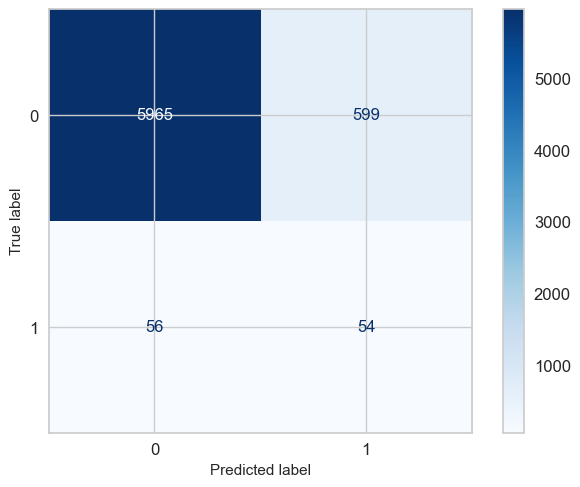

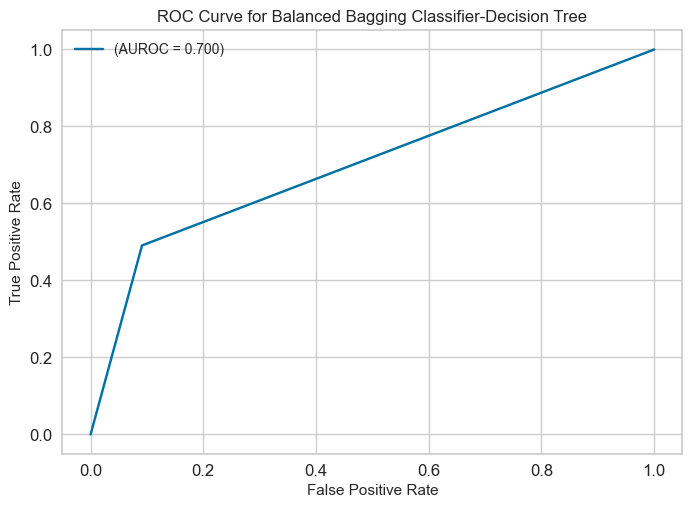

In [72]:
dt_bbc=BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                             n_estimators=100,
                             sampling_strategy='auto',
                             replacement=False,
                             random_state=0)

dt_bbc.fit(X_train,y_train)
dt_bbc_predict=dt_bbc.predict(x_test)

print('Balanced Bagging Classifier-Decision Tree')
dt_bbc_predict_acc=accuracy_score(y_test,dt_bbc_predict)
print('Accuracy score: ',dt_bbc_predict_acc)
dt_bbc_predict_roc=roc_auc_score(y_test,dt_bbc_predict)
print('ROC_AUC_Score: ',dt_bbc_predict_roc)

print(classification_report(y_test,dt_bbc_predict))
fun_plot_confusion_matrix(y_test,dt_bbc_predict,dt_bbc)
fun_plot_roc_curve(y_test,dt_bbc_predict,'ROC Curve for Balanced Bagging Classifier-Decision Tree')

roc_auc_scoring=roc_auc_score(y_test,dt_bbc_predict)
dt_bbc_predict_precision_score,dt_bbc_predict_recall_score,dt_bbc_predict_f1_score,_=precision_recall_fscore_support(y_test,dt_bbc_predict,average='weighted')
result_list.append(['Balanced Bagging Classifier (DecisionTree)',dt_bbc_predict_acc,dt_bbc_predict_roc,dt_bbc_predict_precision_score,dt_bbc_predict_recall_score,dt_bbc_predict_f1_score])

In [73]:
import pickle
filename = 'bbc_dt_pic.sav'
pickle.dump(dt_bbc, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.901857956248127


In [74]:
from joblib import dump, load
dump(xgb_model, 'xgb_jl.joblib')

['xgb_jl.joblib']

# 5 Modelling Part 2

# Neural Network MLP Classifier

## RandomisedSearchCV

The cell below is commented due to long execution time for tuning during every compilation, however, the beast parameters tuned previously is saved and implemented in the next cell.

In [75]:
# from sklearn.neural_network import MLPClassifier
# mlp_rs_classifier = MLPClassifier()
# rs_params = {
#     'hidden_layer_sizes': [(1,),(50,),(100,)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],
# }
# mlp_rs_model=RandomizedSearchCV(mlp_rs_classifier,param_distributions=rs_params,n_iter=100,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
# mlp_rs_model.fit(X,y)
# mlp_rs_model.best_params_

In [76]:
# Best Parameters from Randomizedsearch CV
# {'solver': 'adam',
#  'learning_rate': 'constant',
#  'hidden_layer_sizes': (100,),
#  'alpha': 0.0001,
#  'activation': 'relu'}

from sklearn.neural_network import MLPClassifier
mlp_rs_classifier = MLPClassifier()
rs_params = {'solver': ['adam'],
 'learning_rate': ['constant'],
 'hidden_layer_sizes': [(100,)],
 'alpha': [0.0001],
 'activation': ['relu']}

mlp_rs_model=RandomizedSearchCV(mlp_rs_classifier,param_distributions=rs_params,n_iter=100,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
mlp_rs_model.fit(X,y)
mlp_rs_model.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'solver': 'adam',
 'learning_rate': 'constant',
 'hidden_layer_sizes': (100,),
 'alpha': 0.0001,
 'activation': 'relu'}

MLP-RandomisedSearch
Accuracy score:  0.9391669163919688
ROC_AUC_Score:  0.6696318763503406
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      6564
           1       0.11      0.39      0.17       110

    accuracy                           0.94      6674
   macro avg       0.55      0.67      0.57      6674
weighted avg       0.97      0.94      0.96      6674



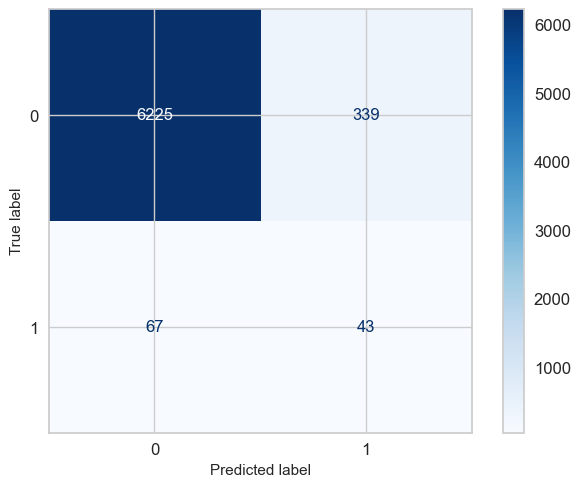

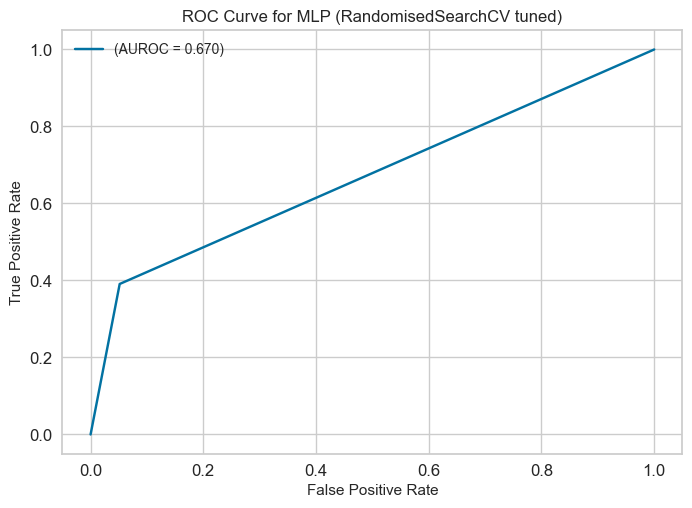

Top 10 features bassed on mutual information 

Index(['Income', 'Employment_length', 'Age', 'Family_member_count',
       'Employment_status_Working', 'Marital_status_Married',
       'Dwelling_House_apartment', 'Employment_status_Commercial_associate',
       'Own_phone_N', 'Own_property_Y'],
      dtype='object')


In [77]:
mlp_rs_model_tuned=mlp_rs_model.best_estimator_
mlp_rs_model_tuned.fit(X_bal,y_bal)
mlp_rs_model_preds=mlp_rs_model_tuned.predict(x_test)

print('MLP-RandomisedSearch')
mlp_rs_model_preds_acc=accuracy_score(y_test,mlp_rs_model_preds)
print('Accuracy score: ',accuracy_score(y_test,mlp_rs_model_preds))
mlp_rs_model_preds_roc=roc_auc_score(y_test,mlp_rs_model_preds)
print('ROC_AUC_Score: ',mlp_rs_model_preds_roc)

print(classification_report(y_test,mlp_rs_model_preds))

fun_plot_confusion_matrix(y_test,mlp_rs_model_preds,mlp_rs_model_tuned)
fun_plot_roc_curve(y_test,mlp_rs_model_preds,'ROC Curve for MLP (RandomisedSearchCV tuned)')

from sklearn.feature_selection import mutual_info_classif
print("Top 10 features bassed on mutual information","\n")
# Select the top 10 features using mutual information
selector = mutual_info_classif(X_bal, y_bal)
print(X_bal.columns[selector.argsort()[::-1][:10]])

mlp_rs_model_preds_precision_score,mlp_rs_model_preds_recall_score,mlp_rs_model_preds_f1_score,_=precision_recall_fscore_support(y_test,mlp_rs_model_preds,average='weighted')
result_list.append(['MLP (RandomisedSearchCV)',mlp_rs_model_preds_acc,mlp_rs_model_preds_roc,mlp_rs_model_preds_precision_score,mlp_rs_model_preds_recall_score,mlp_rs_model_preds_f1_score])

## MLP Clasifier (GridSearchCV)

The cell below is commented due to long execution time for tuning during every compilation, however, the beast parameters tuned previously is saved and implemented in the next cell.

In [78]:
# mlp_gs_classifier = MLPClassifier()
# gs_params = {
#     'hidden_layer_sizes': [(1,),(50,),(100,)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],
# }
# mlp_gs_model=GridSearchCV(mlp_gs_classifier,param_grid=gs_params,scoring='neg_log_loss',n_jobs=-1,cv=5,verbose=3)
# mlp_gs_model.fit(X,y)
# mlp_gs_model.best_params_

In [79]:
# Best Parameters from Gridsearch CV
# {'activation': 'tanh',
# 'alpha': 0.0001,
# 'hidden_layer_sizes': (1,),
# 'learning_rate': 'adaptive',
# 'solver': 'adam'}
mlp_gs_classifier = MLPClassifier()
gs_params = {
'activation': ['tanh'],
'alpha': [0.0001],
'hidden_layer_sizes': [(1,)],
'learning_rate': ['adaptive'],
'solver': ['adam']}

mlp_gs_model=GridSearchCV(mlp_gs_classifier,param_grid=gs_params,scoring='neg_log_loss',n_jobs=-1,cv=5,verbose=3)
mlp_gs_model.fit(X,y)
mlp_gs_model.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'activation': 'tanh',
 'alpha': 0.0001,
 'hidden_layer_sizes': (1,),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

MLP-GridSearch
Accuracy score:  0.6258615522924783
ROC_AUC_Score:  0.5014154340479752
              precision    recall  f1-score   support

           0       0.98      0.63      0.77      6564
           1       0.02      0.37      0.03       110

    accuracy                           0.63      6674
   macro avg       0.50      0.50      0.40      6674
weighted avg       0.97      0.63      0.76      6674



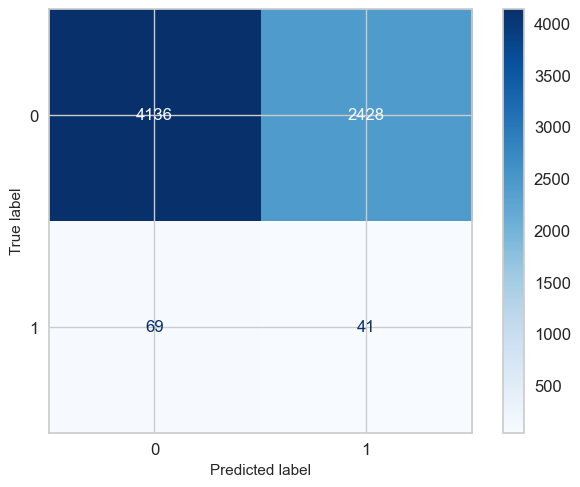

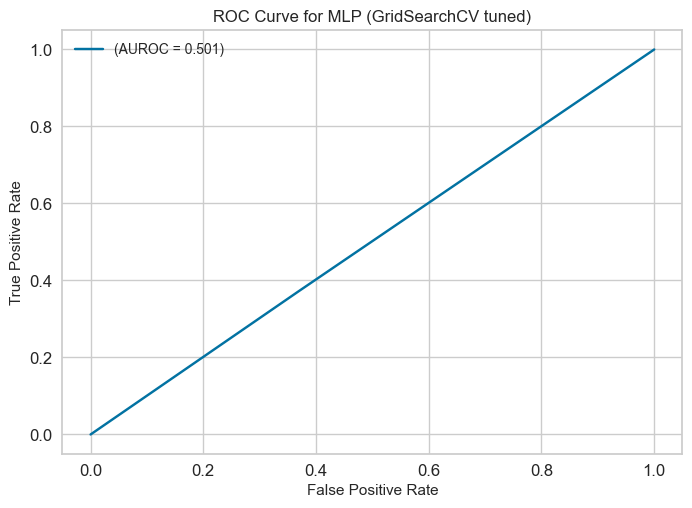

Top 10 features bassed on mutual information 

Index(['Income', 'Employment_length', 'Age', 'Family_member_count',
       'Marital_status_Married', 'Employment_status_Working',
       'Dwelling_House_apartment', 'Employment_status_Commercial_associate',
       'Gender_M', 'Own_phone_N'],
      dtype='object')


In [80]:
mlp_gs_model_tuned=mlp_gs_model.best_estimator_
mlp_gs_model_tuned.fit(X_bal,y_bal)
mlp_gs_model_preds=mlp_gs_model_tuned.predict(x_test)

print('MLP-GridSearch')
mlp_gs_model_preds_acc=accuracy_score(y_test,mlp_gs_model_preds)
mlp_gs_model_preds_roc=roc_auc_score(y_test,mlp_gs_model_preds)
print('Accuracy score: ',mlp_gs_model_preds_acc)
print('ROC_AUC_Score: ',mlp_gs_model_preds_roc)
print(classification_report(y_test,mlp_gs_model_preds))

fun_plot_confusion_matrix(y_test,mlp_gs_model_preds,mlp_gs_model_tuned)
fun_plot_roc_curve(y_test,mlp_gs_model_preds,'ROC Curve for MLP (GridSearchCV tuned)')

from sklearn.feature_selection import mutual_info_classif
print("Top 10 features bassed on mutual information","\n")
# Select the top 10 features using mutual information
selector = mutual_info_classif(X_bal, y_bal)
print(X_bal.columns[selector.argsort()[::-1][:10]])

mlp_gs_model_preds_precision_score,mlp_gs_model_preds_recall_score,mlp_gs_model_preds_f1_score,_=precision_recall_fscore_support(y_test,mlp_gs_model_preds,average='weighted')
result_list.append(['MLP (GridSearchCV)',mlp_gs_model_preds_acc,mlp_gs_model_preds_roc,mlp_gs_model_preds_precision_score,mlp_gs_model_preds_recall_score,mlp_gs_model_preds_f1_score])

# K-Nearest Neighbors

## K-Nearest Neighbors (RandomisedSearchCV)

The cell below is commented due to long execution time for tuning during every compilation, however, the beast parameters tuned previously is saved and implemented in the next cell.

In [81]:
# knn_rs_classifier = KNeighborsClassifier()
# rs_params = {
#     'leaf_size': np.arange(1,30),
#               'n_neighbors': np.arange(1,21),
#               'p': [1,2]
# }
# knn_rs_model=RandomizedSearchCV(knn_rs_classifier,param_distributions=rs_params,n_iter=100,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
# knn_rs_model.fit(X,y)
# knn_rs_model.best_params_

In [82]:
knn_rs_classifier = KNeighborsClassifier()

rs_params = {'p': [1], 'n_neighbors': [5], 'leaf_size': [4]}
knn_rs_model=RandomizedSearchCV(knn_rs_classifier,param_distributions=rs_params,n_iter=100,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
knn_rs_model.fit(X,y)
knn_rs_model.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'p': 1, 'n_neighbors': 5, 'leaf_size': 4}

KNN-RandomisedSearch
Accuracy score:  0.9683847767455799
ROC_AUC_Score:  0.6353235277823944
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      6564
           1       0.19      0.29      0.23       110

    accuracy                           0.97      6674
   macro avg       0.59      0.64      0.61      6674
weighted avg       0.97      0.97      0.97      6674



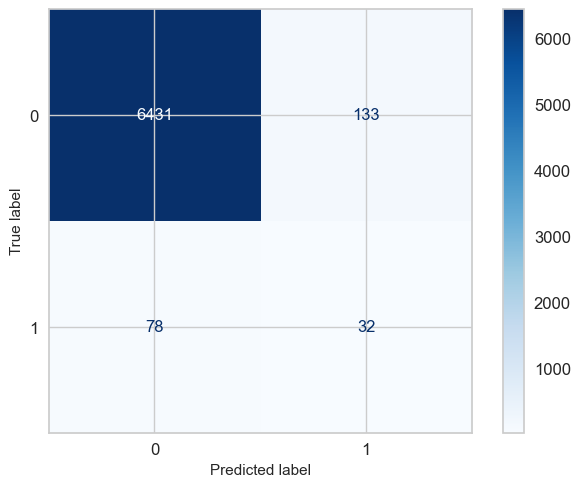

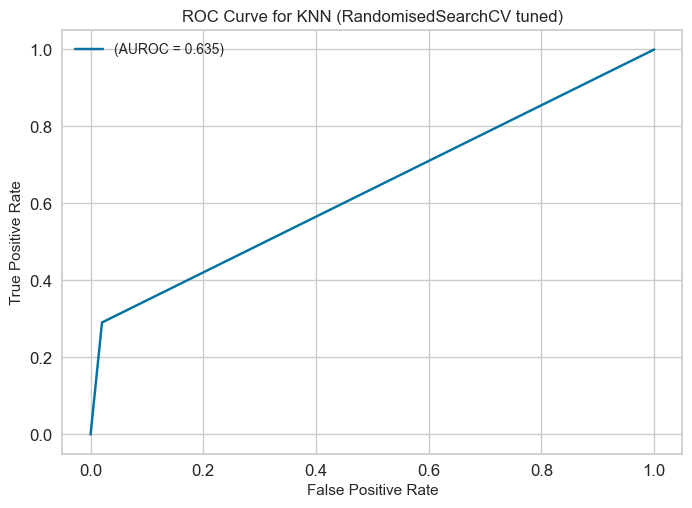

Top 10 featres bassed on mutual information 

Index(['Income', 'Employment_length', 'Age', 'Family_member_count',
       'Employment_status_Working', 'Employment_status_Commercial_associate',
       'Marital_status_Married', 'Dwelling_House_apartment', 'Gender_M',
       'Own_phone_N'],
      dtype='object')


In [84]:
knn_rs_model_tuned=knn_rs_model.best_estimator_
knn_rs_model_tuned.fit(X_bal,y_bal)
knn_rs_model_preds=knn_rs_model_tuned.predict(x_test)

print('KNN-RandomisedSearch')
knn_rs_model_pred_accs=accuracy_score(y_test,knn_rs_model_preds)
knn_rs_model_preds_roc=roc_auc_score(y_test,knn_rs_model_preds)
print('Accuracy score: ',knn_rs_model_pred_accs)
print('ROC_AUC_Score: ',knn_rs_model_preds_roc)
print(classification_report(y_test,knn_rs_model_preds))

fun_plot_confusion_matrix(y_test,knn_rs_model_preds,knn_rs_model_tuned)
fun_plot_roc_curve(y_test,knn_rs_model_preds,'ROC Curve for KNN (RandomisedSearchCV tuned)')

from sklearn.feature_selection import mutual_info_classif
print("Top 10 featres bassed on mutual information","\n")
# Select the top 10 features using mutual information
selector = mutual_info_classif(X_bal, y_bal, n_neighbors=10)
print(X_bal.columns[selector.argsort()[::-1][:10]])

knn_rs_model_preds_precision_score,knn_rs_model_preds_recall_score,knn_rs_model_preds_f1_score,_=precision_recall_fscore_support(y_test,knn_rs_model_preds,average='weighted')
result_list.append(['KNN (RandomisedSearchCV)',knn_rs_model_pred_accs,knn_rs_model_preds_roc,knn_rs_model_preds_precision_score,knn_rs_model_preds_recall_score,knn_rs_model_preds_f1_score])

## K-Nearest Neighbors (GridSearchCV)

The cell below is commented due to long execution time for tuning during every compilation, however, the beast parameters tuned previously is saved and implemented in the next cell.

In [85]:
# knn_gs_classifier = KNeighborsClassifier()
# gs_params = {
#     'leaf_size': [11,13,15,17,19,21],
#     'n_neighbors': [3,5,7,9,11],
#     'p': [1,2]
# }
# knn_gs_model=GridSearchCV(knn_gs_classifier,param_grid=gs_params,scoring='neg_log_loss',n_jobs=-1,cv=5,verbose=3)
# knn_gs_model.fit(X,y)
# knn_gs_model.best_params_

In [86]:
knn_gs_classifier = KNeighborsClassifier()
gs_params ={'leaf_size': [11], 'n_neighbors': [3], 'p': [1]}
knn_gs_model=GridSearchCV(knn_gs_classifier,param_grid=gs_params,scoring='neg_log_loss',n_jobs=-1,cv=5,verbose=3)
knn_gs_model.fit(X,y)
knn_gs_model.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'leaf_size': 11, 'n_neighbors': 3, 'p': 1}

KNN-GridSearch
Accuracy score:  0.9740785136350015
ROC_AUC_Score:  0.629279541299651
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6564
           1       0.24      0.27      0.26       110

    accuracy                           0.97      6674
   macro avg       0.62      0.63      0.62      6674
weighted avg       0.98      0.97      0.97      6674



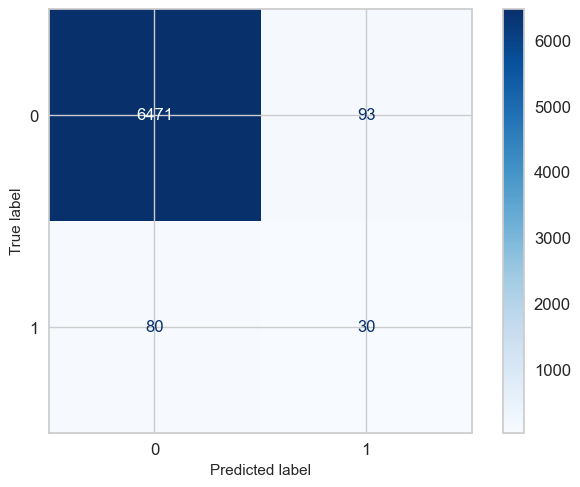

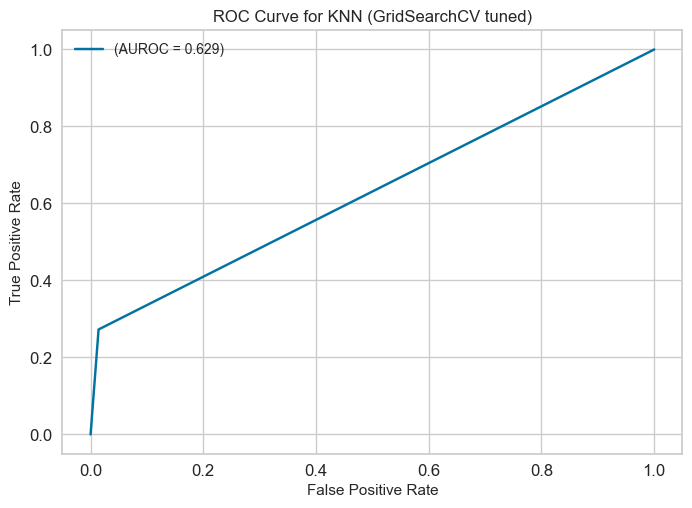

Top 10 featres bassed on mutual information 

Index(['Income', 'Employment_length', 'Age', 'Family_member_count',
       'Employment_status_Working', 'Marital_status_Married',
       'Dwelling_House_apartment', 'Employment_status_Commercial_associate',
       'Own_phone_N', 'Gender_M'],
      dtype='object')


In [87]:
knn_gs_model_tuned=knn_gs_model.best_estimator_
knn_gs_model_tuned.fit(X_bal,y_bal)
knn_gs_model_preds=knn_gs_model_tuned.predict(x_test)

print('KNN-GridSearch')
knn_gs_model_preds_acc=accuracy_score(y_test,knn_gs_model_preds)
knn_gs_model_preds_roc=roc_auc_score(y_test,knn_gs_model_preds)
print('Accuracy score: ',knn_gs_model_preds_acc)
print('ROC_AUC_Score: ',knn_gs_model_preds_roc)
print(classification_report(y_test,knn_gs_model_preds))

fun_plot_confusion_matrix(y_test,knn_gs_model_preds,knn_gs_model_tuned)
fun_plot_roc_curve(y_test,knn_gs_model_preds,'ROC Curve for KNN (GridSearchCV tuned)')

from sklearn.feature_selection import mutual_info_classif
print("Top 10 featres bassed on mutual information","\n")
# Select the top 10 features using mutual information
selector = mutual_info_classif(X_bal, y_bal, n_neighbors=10)
print(X_bal.columns[selector.argsort()[::-1][:10]])

knn_gs_model_preds_precision_score,knn_gs_model_preds_recall_score,knn_gs_model_preds_f1_score,_=precision_recall_fscore_support(y_test,knn_gs_model_preds,average='weighted')
result_list.append(['KNN (GridSearchCV)',knn_gs_model_preds_acc,knn_gs_model_preds_roc,knn_gs_model_preds_precision_score,knn_gs_model_preds_recall_score,knn_gs_model_preds_f1_score])

# Gaussian Naive Bayes

## Gaussian Naive Bayes (RandomisedSearchCV)

The cell below is commented due to long execution time for tuning during every compilation, however, the beast parameters tuned previously is saved and implemented in the next cell.

In [88]:
# gnb_rs_classifier = GaussianNB()
# rs_params = {
#     'var_smoothing': np.logspace(0,-9, num=100)
# }
# gnb_rs_model=RandomizedSearchCV(gnb_rs_classifier,param_distributions=rs_params,n_iter=100,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
# gnb_rs_model.fit(X,y)
# gnb_rs_model.best_params_

In [89]:
gnb_rs_classifier = GaussianNB()
rs_params = {'var_smoothing': [1.0]}
gnb_rs_model=RandomizedSearchCV(gnb_rs_classifier,param_distributions=rs_params,n_iter=100,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
gnb_rs_model.fit(X,y)
gnb_rs_model.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'var_smoothing': 1.0}

GNB-RandomisedSearch
Accuracy score:  0.17860353611027868
ROC_AUC_Score:  0.5377264417483796
              precision    recall  f1-score   support

           0       0.99      0.17      0.28      6564
           1       0.02      0.91      0.04       110

    accuracy                           0.18      6674
   macro avg       0.50      0.54      0.16      6674
weighted avg       0.97      0.18      0.28      6674



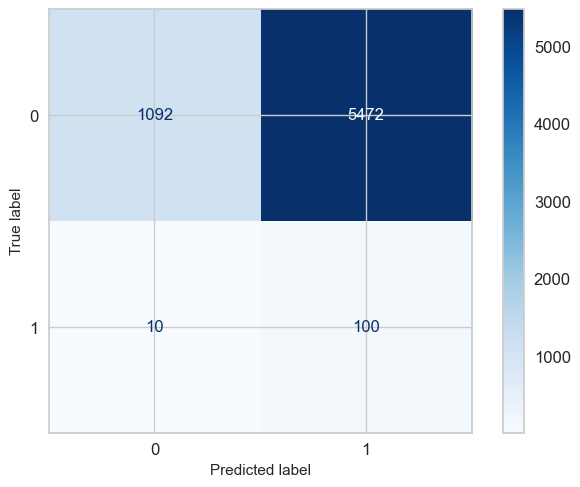

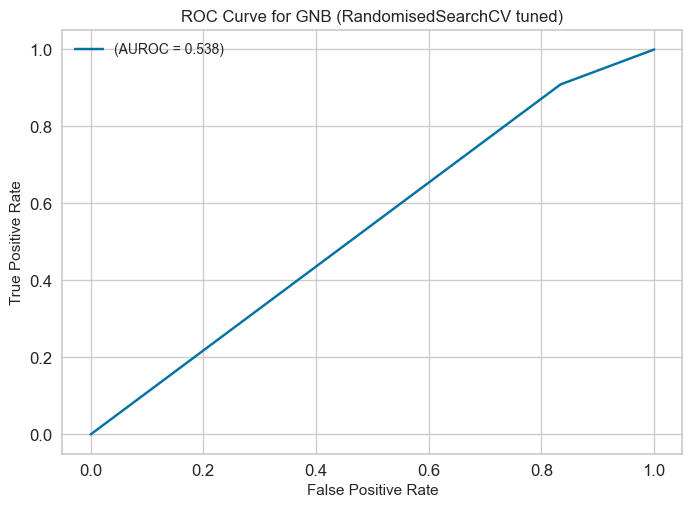

Top 10 features bassed on mutual information 

Index(['Income', 'Employment_length', 'Age', 'Family_member_count',
       'Employment_status_Working', 'Marital_status_Married',
       'Dwelling_House_apartment', 'Own_phone_N',
       'Employment_status_Commercial_associate', 'Gender_M'],
      dtype='object')


In [90]:
gnb_rs_model_tuned=gnb_rs_model.best_estimator_
gnb_rs_model_tuned.fit(X_bal,y_bal)
gnb_rs_model_preds=gnb_rs_model_tuned.predict(x_test)

print('GNB-RandomisedSearch')
gnb_rs_model_preds_acc=accuracy_score(y_test,gnb_rs_model_preds)
gnb_rs_model_preds_roc=roc_auc_score(y_test,gnb_rs_model_preds)
print('Accuracy score: ',gnb_rs_model_preds_acc)
print('ROC_AUC_Score: ',gnb_rs_model_preds_roc)
print(classification_report(y_test,gnb_rs_model_preds))

fun_plot_confusion_matrix(y_test,gnb_rs_model_preds,gnb_rs_model_tuned)
fun_plot_roc_curve(y_test,gnb_rs_model_preds,'ROC Curve for GNB (RandomisedSearchCV tuned)')

from sklearn.feature_selection import mutual_info_classif
print("Top 10 features bassed on mutual information","\n")
# Select the top 10 features using mutual information
selector = mutual_info_classif(X_bal, y_bal)
print(X_bal.columns[selector.argsort()[::-1][:10]])

gnb_rs_model_preds_precision_score,gnb_rs_model_preds_recall_score,gnb_rs_model_preds_f1_score,_=precision_recall_fscore_support(y_test,gnb_rs_model_preds,average='weighted')
result_list.append(['GNB (RandomisedSearchCV)',gnb_rs_model_preds_acc,gnb_rs_model_preds_roc,gnb_rs_model_preds_precision_score,gnb_rs_model_preds_recall_score,gnb_rs_model_preds_f1_score])

## Gaussian Naive Bayes (GridSearchCV)

The cell below is commented due to long execution time for tuning during every compilation, however, the beast parameters tuned previously is saved and implemented in the next cell.

In [91]:
# gnb_gs_classifier = GaussianNB()
# gs_params = {
#     'var_smoothing': np.logspace(0,-9, num=100)
# }
# gnb_gs_model=GridSearchCV(gnb_gs_classifier,param_grid=gs_params,scoring='neg_log_loss',n_jobs=-1,cv=5,verbose=3)
# gnb_gs_model.fit(X,y)
# gnb_gs_model.best_params_

In [92]:
gnb_gs_classifier = GaussianNB()
gs_params = {
    'var_smoothing':[1.0]
}
gnb_gs_model=GridSearchCV(gnb_gs_classifier,param_grid=gs_params,scoring='neg_log_loss',n_jobs=-1,cv=5,verbose=3)
gnb_gs_model.fit(X,y)
gnb_gs_model.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'var_smoothing': 1.0}

GNB-GridSearch
Accuracy score:  0.17860353611027868
ROC_AUC_Score:  0.5377264417483796
              precision    recall  f1-score   support

           0       0.99      0.17      0.28      6564
           1       0.02      0.91      0.04       110

    accuracy                           0.18      6674
   macro avg       0.50      0.54      0.16      6674
weighted avg       0.97      0.18      0.28      6674



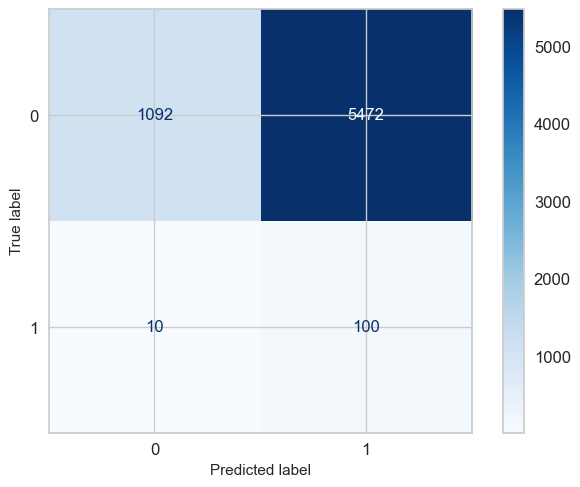

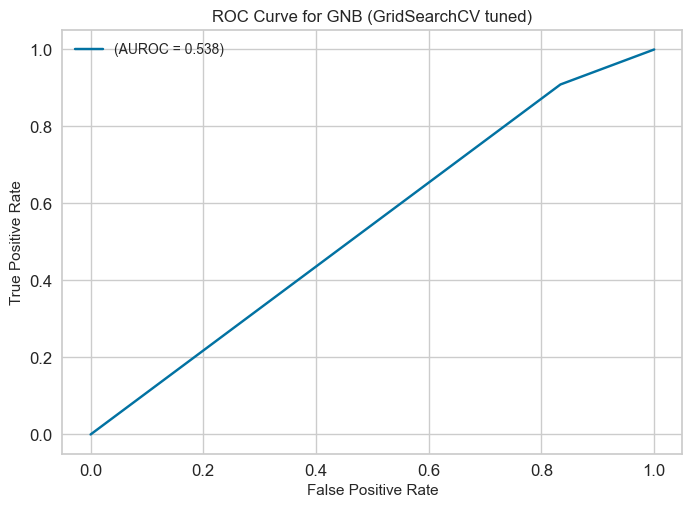

Top 10 features bassed on mutual information 

Index(['Income', 'Employment_length', 'Age', 'Family_member_count',
       'Employment_status_Working', 'Marital_status_Married',
       'Employment_status_Commercial_associate', 'Dwelling_House_apartment',
       'Own_phone_N', 'Own_property_Y'],
      dtype='object')


In [94]:
gnb_gs_model_tuned=gnb_gs_model.best_estimator_
gnb_gs_model_tuned.fit(X_bal,y_bal)
gnb_gs_model_preds=gnb_gs_model_tuned.predict(x_test)

print('GNB-GridSearch')
gnb_gs_model_preds_acc=accuracy_score(y_test,gnb_gs_model_preds)
gnb_gs_model_preds_roc=roc_auc_score(y_test,gnb_gs_model_preds)
print('Accuracy score: ',gnb_gs_model_preds_acc)
print('ROC_AUC_Score: ',gnb_gs_model_preds_roc)
print(classification_report(y_test,gnb_gs_model_preds))

fun_plot_confusion_matrix(y_test,gnb_gs_model_preds,gnb_gs_model_tuned)
fun_plot_roc_curve(y_test,gnb_gs_model_preds,'ROC Curve for GNB (GridSearchCV tuned)')

from sklearn.feature_selection import mutual_info_classif
print("Top 10 features bassed on mutual information","\n")
# Select the top 10 features using mutual information
selector = mutual_info_classif(X_bal, y_bal)
print(X_bal.columns[selector.argsort()[::-1][:10]])

gnb_gs_model_preds_precision_score,gnb_gs_model_preds_recall_score,gnb_gs_model_preds_f1_score,_=precision_recall_fscore_support(y_test,gnb_gs_model_preds,average='weighted')
result_list.append(['GNB (GridSearchCV)',gnb_gs_model_preds_acc,gnb_gs_model_preds_roc,gnb_gs_model_preds_precision_score,gnb_gs_model_preds_recall_score,gnb_gs_model_preds_f1_score])

In [95]:
result_list

[['Random Forest (RandomisedSearchCV)',
  0.980521426430926,
  0.6504321090244307,
  0.978536690417947,
  0.980521426430926,
  0.9794555773186883],
 ['Random Forest (GridSearhCV)',
  0.9802217560683248,
  0.6458104814137722,
  0.9782000617723177,
  0.9802217560683248,
  0.9791395092774374],
 ['XGBoost-Default',
  0.9797722505244232,
  0.627704836297158,
  0.97718992374178,
  0.9797722505244232,
  0.978378114368828],
 ['XGBoost (RandomisedSearchCV)',
  0.9788732394366197,
  0.6227785164256827,
  0.976579056097244,
  0.9788732394366197,
  0.9776584258527818],
 ['XGBoost (GridSearchCV)',
  0.9748276895415043,
  0.61178328070467,
  0.9748276895415043,
  0.9748276895415043,
  0.9748276895415043],
 ['Balanced Bagging Classifier (XGBoost)',
  0.8224453101588253,
  0.6639244363193175,
  0.9744282202795768,
  0.8224453101588253,
  0.8882227902142468],
 ['Balanced Bagging Classifier (DecisionTree)',
  0.901857956248127,
  0.6998268793972634,
  0.9757336161115261,
  0.901857956248127,
  0.9346628

# Result

In [96]:
result=pd.DataFrame(result_list, columns =['Algorithm','Accuracy','ROC_AUC acore','Precision', 'Recall','f1-score'], dtype = float)
result

,Algorithm,Accuracy,ROC_AUC acore,Precision,Recall,f1-score
0,Random Forest (RandomisedSearchCV),0.980521,0.650432,0.978537,0.980521,0.979456
1,Random Forest (GridSearhCV),0.980222,0.645810,0.978200,0.980222,0.979140
2,XGBoost-Default,0.979772,0.627705,0.977190,0.979772,0.978378
3,XGBoost (RandomisedSearchCV),0.978873,0.622779,0.976579,0.978873,0.977658
4,XGBoost (GridSearchCV),0.974828,0.611783,0.974828,0.974828,0.974828
5,Balanced Bagging Classifier (XGBoost),0.822445,0.663924,0.974428,0.822445,0.888223
6,Balanced Bagging Classifier (DecisionTree),0.901858,0.699827,0.975734,0.901858,0.934663
7,MLP (RandomisedSearchCV),0.939167,0.669632,0.974900,0.939167,0.955339
8,MLP (GridSearchCV),0.625862,0.501415,0.967653,0.625862,0.755995
9,KNN (RandomisedSearchCV),0.968385,0.635324,0.974929,0.968385,0.971480
